In [42]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import os

from ssd_training import plot_log

In [43]:
from math import log10, floor, ceil

def plot_log(log_file, names=None, limits=None, window_length=250, log_file_compare=None):
    
    def load_log(log_file):
        with open(log_file,'r') as f:
            data = f.readlines()
        keys = json.loads(data[0]).keys()
        d = {k:[] for k in keys}
        for i, line in enumerate(data):
            if not limits == None and (i < limits[0] or i > limits[1]):
                continue
            dat = json.loads(line)
            for k in keys:
                d[k].append(dat[k])
        d = {k:np.array(d[k]) for k in keys}
        return d
    
    d = load_log(log_file)
    print(log_file)
    
    if log_file_compare is not None:
        d2 = load_log(log_file_compare)
        print(log_file_compare)
    
    if names is None:
        names = [k for k in d.keys() if k not in ['epoch', 'batch', 'iteration']]
    else:
        names = [k for k in names if k in d.keys()]
    print(names)

    iteration = d['iteration']
    epoch = d['epoch']
    idx = []
    for i in range(1,len(epoch)):
        if epoch[i] != epoch[i-1]:
            idx.append(i)
    
    # reduce epoch ticks
    max_ticks = 20
    n = len(idx)
    if n > 1:
        n = round(n,-1*floor(log10(n)))
        while n >= max_ticks:
            if n/2 < max_ticks:
                n /= 2
            else:
                if n/5 < max_ticks:
                    n /= 5
                else:
                    n /= 10
        idx_step = ceil(len(idx)/n)
        epoch_step = epoch[idx[idx_step]] - epoch[idx[0]]
        for first_idx in range(len(idx)):
            if epoch[idx[first_idx]] % epoch_step == 0:
                break
        idx_red = [idx[i] for i in range(first_idx, len(idx), idx_step)]
    else:
        idx_red = idx
    
    if window_length is not None:
        #w = np.ones(window_length) # moving average
        w = np.hanning(window_length) # hanning window
        wh = int(window_length/2)
    
    for k in names:
        if k in ['epoch', 'batch', 'iteration', 'time']:
            continue
        plt.figure(figsize=(16, 8))
        plt.plot(iteration, d[k], zorder=0)
        
        # filter signal
        if window_length and len(iteration) > window_length:
            x = iteration[wh-1:-wh]
            y = np.convolve(w/w.sum(), d[k], mode='valid')
            plt.plot(x, y)
        
        # second log
        if log_file_compare is not None and k in d2.keys():
            plt.plot(d2['iteration'], d2[k], zorder=0)
            
            if window_length and len(d2['iteration']) > window_length:
                x = d2['iteration'][wh-1:-wh]
                y = np.convolve(w/w.sum(), d2[k], mode='valid')
                plt.plot(x, y)
        
        xmin = iteration[0]
        xmax = iteration[-1]
        plt.title(k, y=1.05)
        ax1 = plt.gca()
        ax1.set_xlim(xmin, xmax)
        ax1.yaxis.grid(True)
        #ax1.set_xlabel('iteration')
        #ax1.set_yscale('linear')
        ax1.get_yaxis().get_major_formatter().set_useOffset(False)
        
        ax2 = ax1.twiny()
        ax2.xaxis.grid(True)
        ax2.set_xticks(iteration[idx_red])
        ax2.set_xticklabels(epoch[idx_red])
        ax2.set_xlim(xmin, xmax)
        #ax2.set_xlabel('epoch')
        #ax2.set_yscale('linear')
        ax2.get_yaxis().get_major_formatter().set_useOffset(False)
        
        plt.show()

In [44]:
experiments = !ls -1 ./checkpoints
print(experiments.n)

0_crnn_icdar1k
0_crnn_icdar1k_synthtext140k
201709081909_ssd512_voc
201709082315_sl_test
201709091812_sl_test
201709202151_robott
201709222233_robott
201709231742_robott
201709251316_ssd512_coco
201710041551_dsod300_voc
201710052244_robott
201710132146_tb300_synthtext_horizontal10
201710141431_tb300_synthtext_horizontal10
201710202034_sl512_synthtext
201710232202_sl512_synthtext
201710242216_sl512_synthtext
201711071436_sl512_synthtext
201711082300_sl512_synthtext
201711092123_sl512_synthtext_hardFP
201711101623_sl512_synthtext_hardN
201711111814_sl512_synthtext_focal
201711132011_dsodsl512_synthtext
201712111546_ssd1024x768_coco+voc
201712121841_dsodsl512_synthtext_leakyrelu
201712151320_ssd512_coco
201712151328_ssd512_coco
201712151408_ssd512_coco
201712151414_ssd512_coco
201712191111_ssd512_coco
201712192000_ssd512_coco
201712192003_ssd512_coco
201712200926_ssd512_coco
201712201129_ssd512_coco
201801051327_sl_synthtext_ssd_sgd
201801071534_sl_synthtext_ssd_sgd
201801092012_sl_syntht

In [45]:
!rm -rf "checkpoints/201802122339_sl_icdar+0.005synthtext_dsod_adam_focal_icdar_gamma_3_3/"

### Log

./checkpoints/201802170916_sl_icdar+0.005synthtext_dsod_adam_focal_icdar_gamma_2_2.25/log.json
['loss', 'seg_loc_loss', 'seg_fmeasure', 'link_fmeasure', 'seg_precision', 'seg_recall', 'link_precision', 'link_recall']


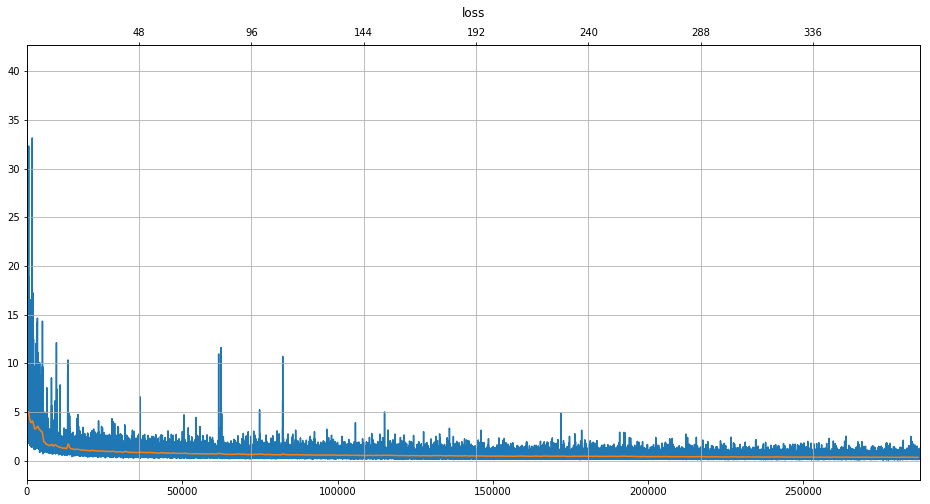

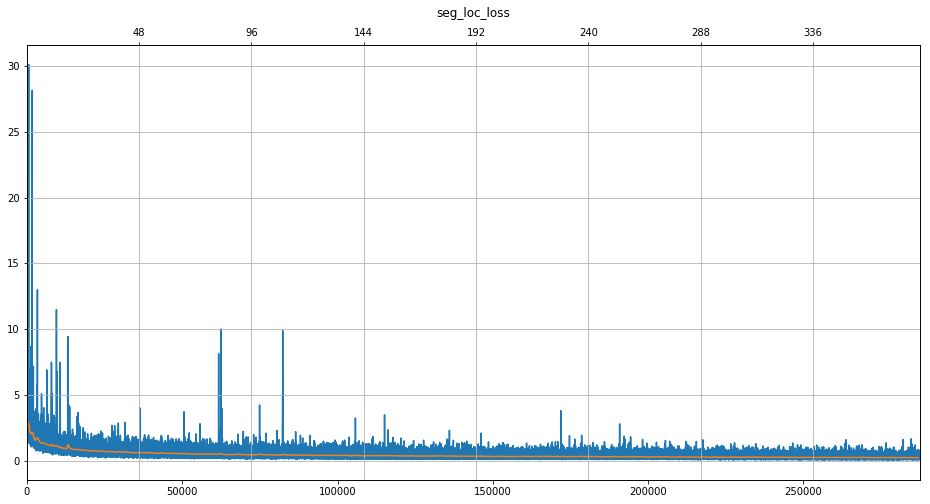

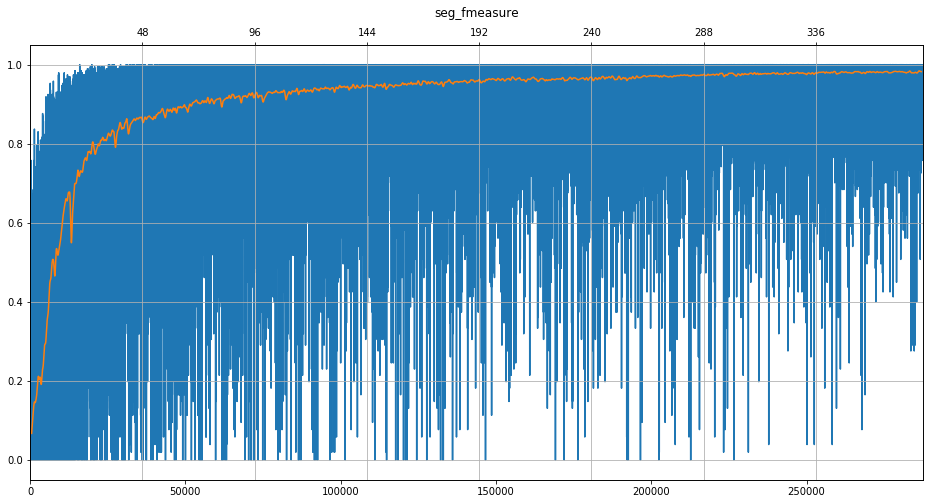

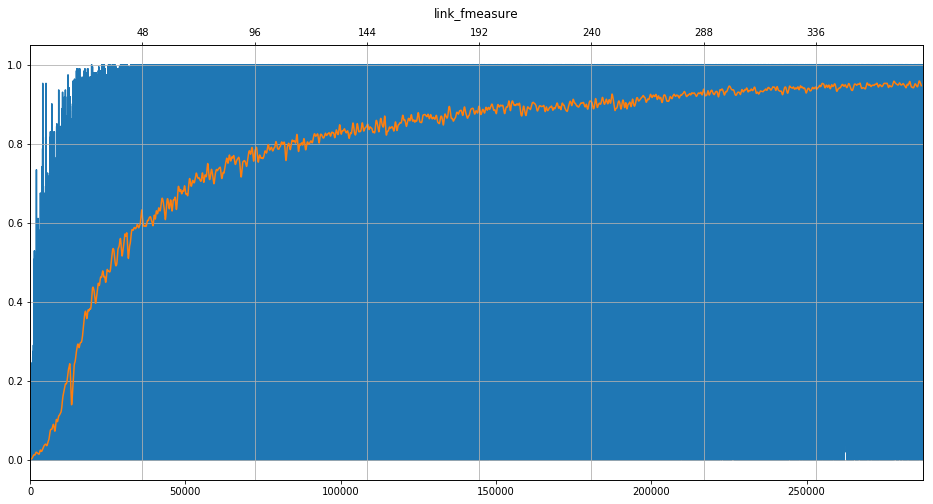

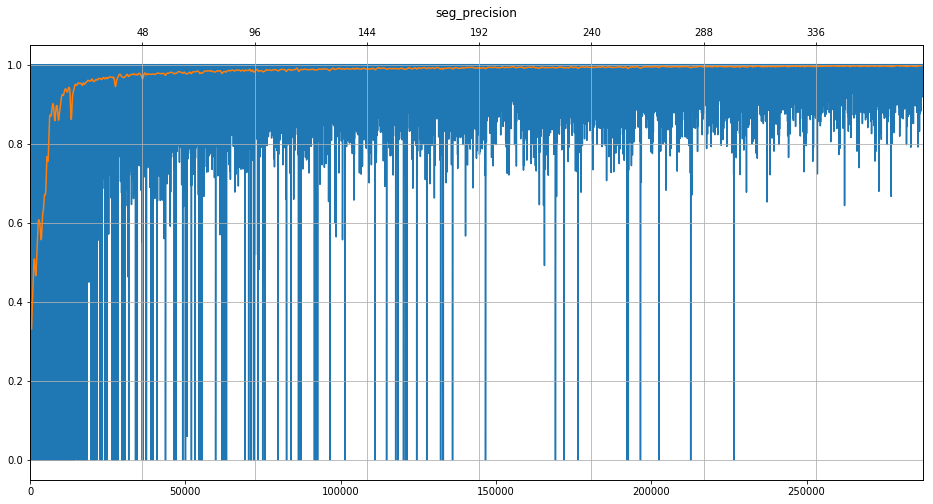

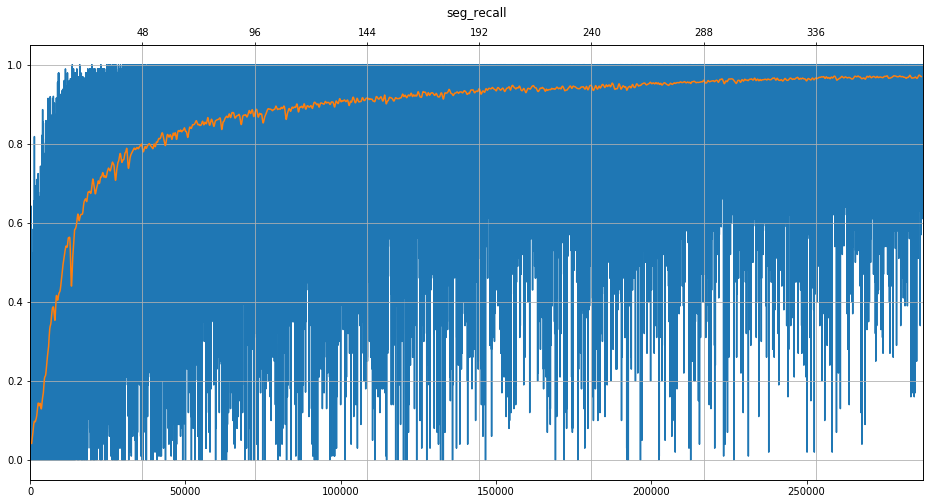

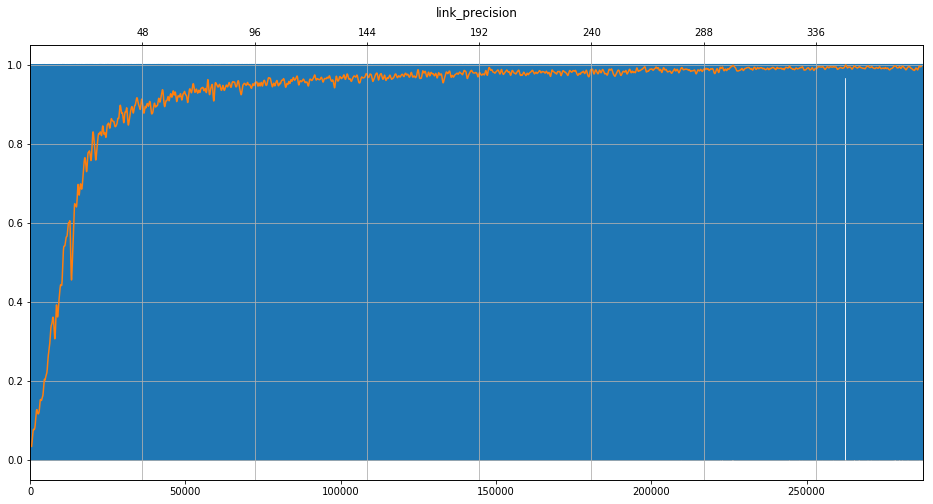

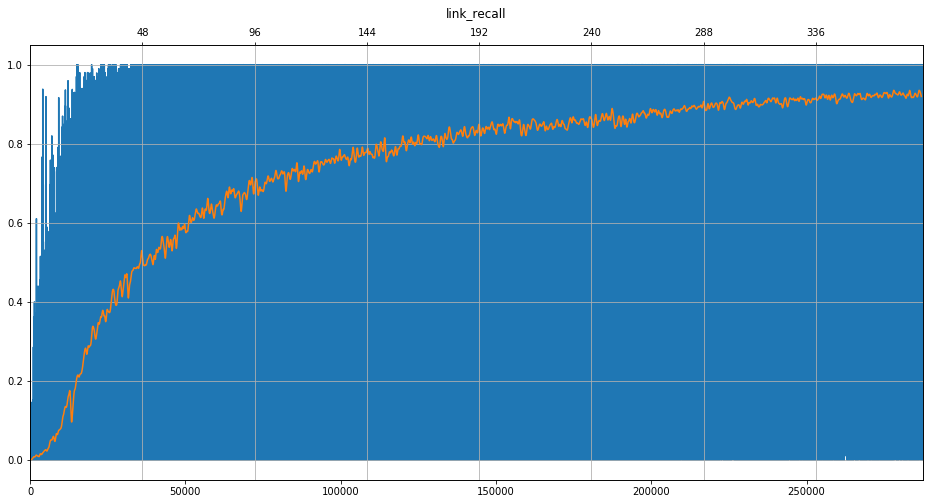

In [46]:
checkdir = './checkpoints/' + experiments[-1]

names = [
    'loss',
    #'lr', 
    #'seg_conf_loss', 'pos_seg_conf_loss', 'neg_seg_conf_loss',
    'seg_loc_loss',
    #'link_conf_loss', 'pos_link_conf_loss', 'neg_link_conf_loss',
    #'num_pos_seg', 'num_neg_seg', 
    #'num_pos_link', 'num_neg_link',
    'seg_fmeasure', 'link_fmeasure',
    'seg_precision', 'seg_recall',
    'link_precision', 'link_recall',
]
#names = None

limits = [100, np.inf]
#limits = [0, 14000]
#limits = [14000, np.inf]
limits = [50000, np.inf]
limits = None

plot_log(checkdir+'/log.json', names, limits, window_length=1000)

### History

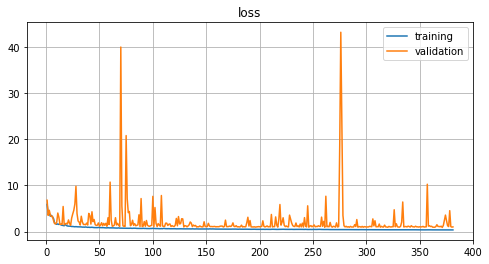

In [47]:
with open(checkdir+'/history.json','r') as f:
    hist = json.load(f)
#print(list(hist.keys()))
epochs = np.arange(1,len(hist['loss'])+1)
plt.figure(figsize=(8,4))
plt.plot(epochs, hist['loss'])
plt.plot(epochs, hist['val_loss'])
plt.title('loss')
plt.legend(['training','validation'])
#plt.xlim([0.0, 8.0])
plt.grid()
plt.show()

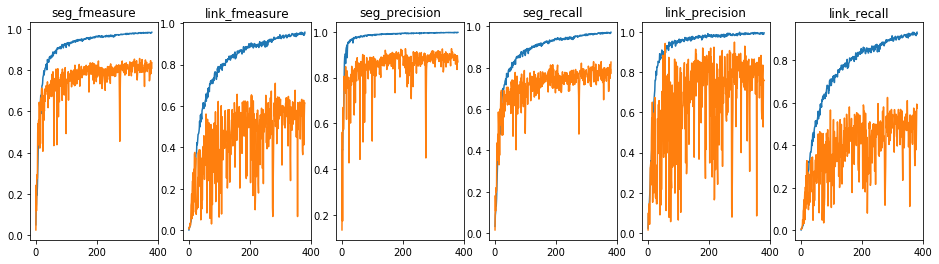

In [48]:
# SSD
signals = ['pos_conf_loss', 'neg_conf_loss', 'pos_loc_loss']

# SegLink
signals = ['pos_seg_conf_loss', 'neg_seg_conf_loss', 'seg_loc_loss', 'pos_link_conf_loss', 'neg_link_conf_loss']
#signals = ['num_pos_seg', 'num_neg_seg', 'num_pos_link', 'num_neg_link']
#signals = ['seg_conf_loss', 'seg_loc_loss', 'link_conf_loss']
signals = ['seg_fmeasure', 'link_fmeasure', 'seg_precision', 'seg_recall', 'link_precision', 'link_recall']

fig, axs = plt.subplots(1, len(signals), figsize=(16,4))
for i, s in enumerate(signals):
    axs[i].plot(epochs, hist[s])
    axs[i].plot(epochs, hist['val_'+s])
    axs[i].set_title(s)
plt.show()

### Compare Log

./checkpoints/201801191029_sl_icdar+0.005synthtext_dsod_adam_focal_icdar/log.json
./checkpoints/201802170916_sl_icdar+0.005synthtext_dsod_adam_focal_icdar_gamma_2_2.25/log.json
['loss', 'seg_loc_loss', 'seg_fmeasure', 'link_fmeasure', 'seg_precision', 'seg_recall', 'link_precision', 'link_recall']


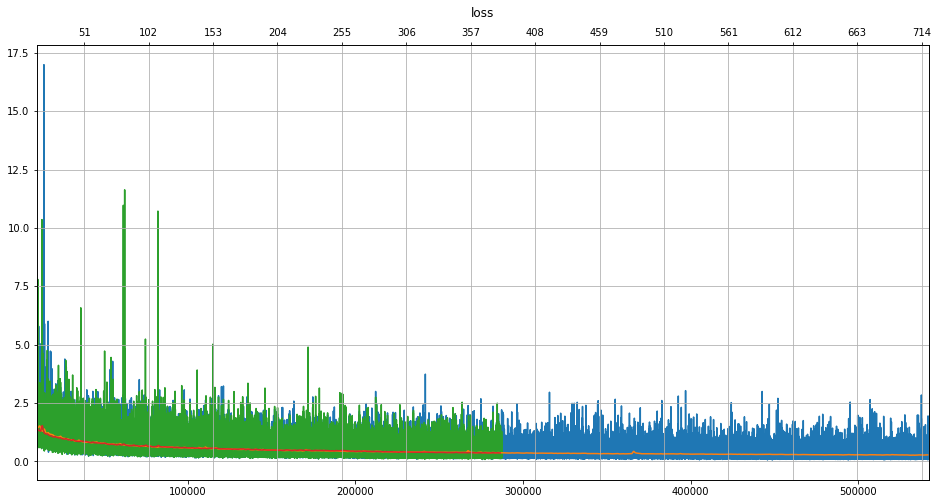

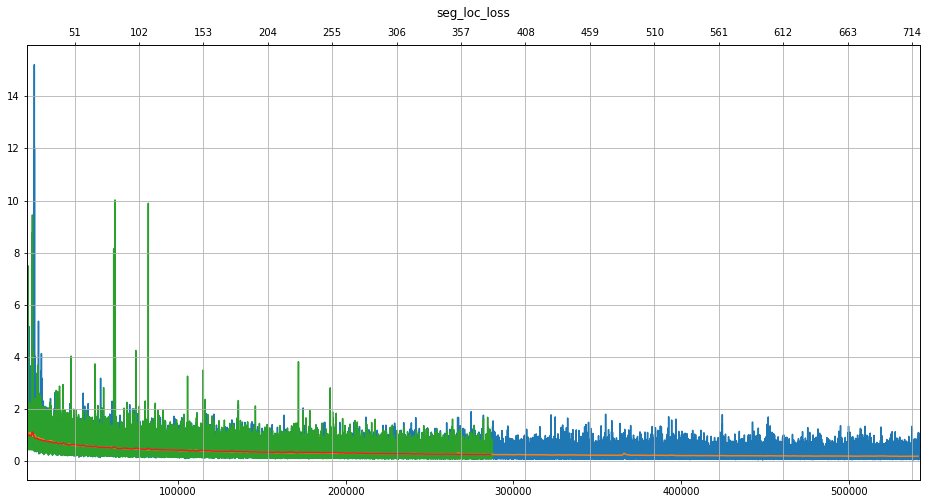

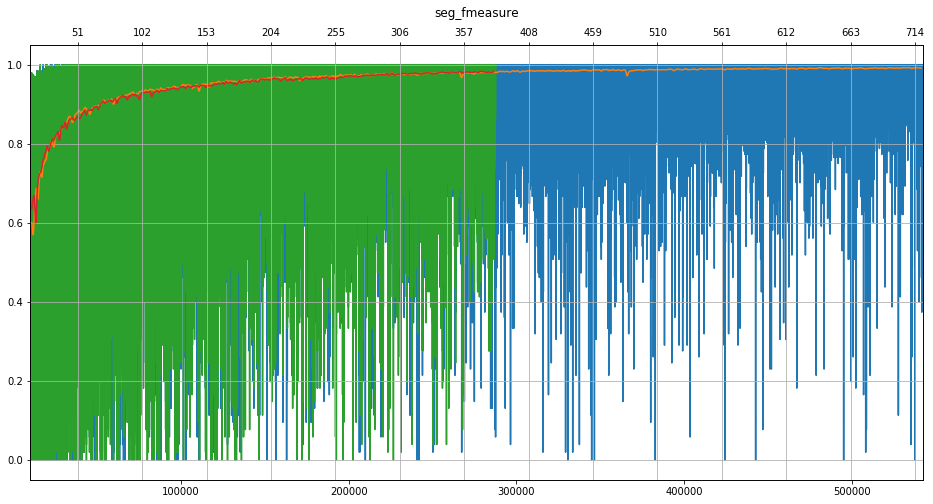

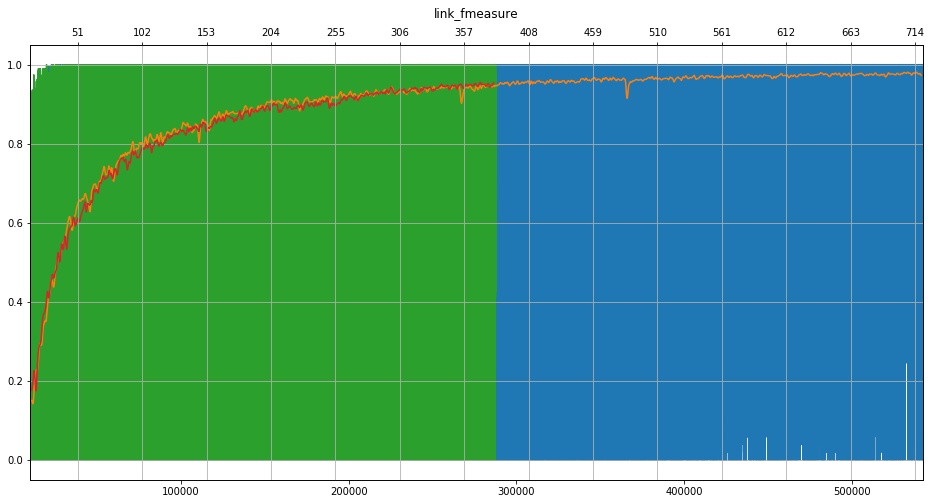

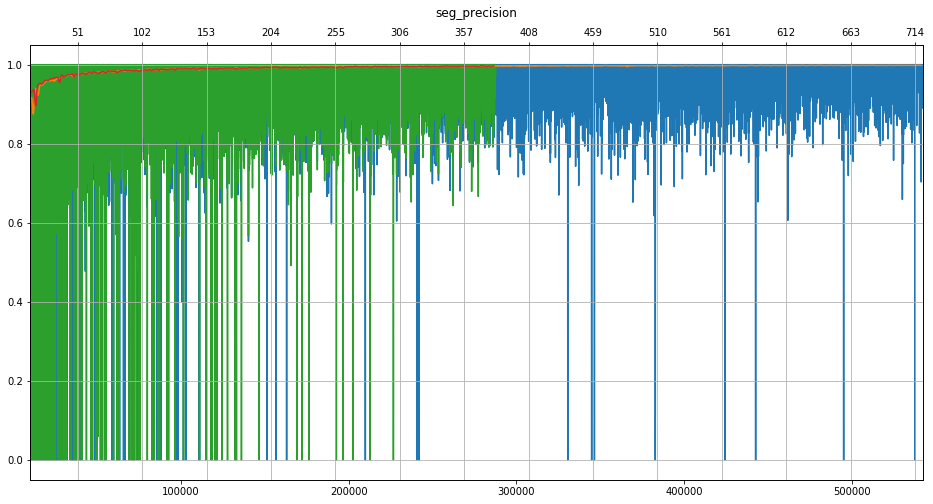

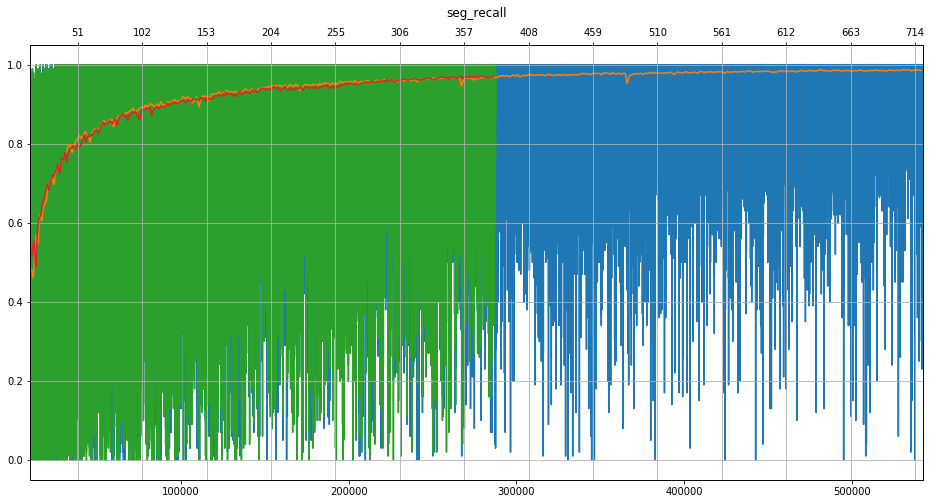

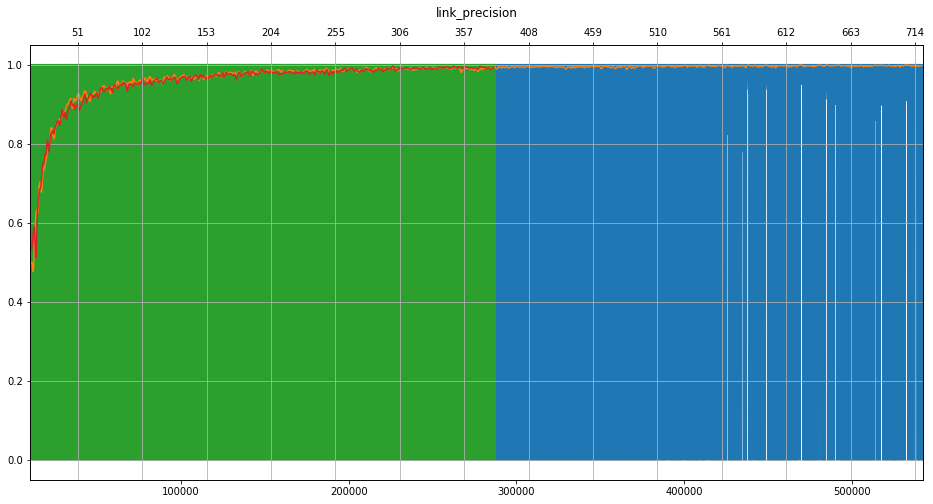

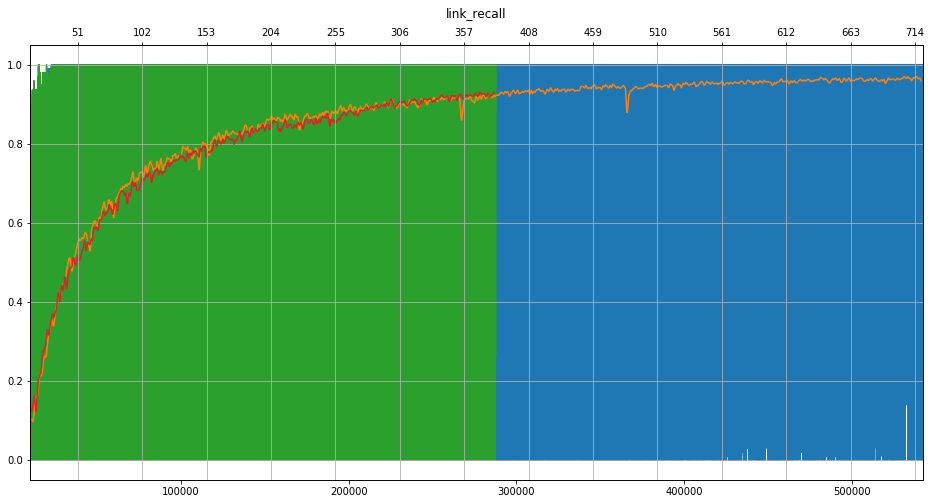

In [49]:
checkdir1 = './checkpoints/201711092123_sl512_synthtext_hardFP'
checkdir1 = './checkpoints/201711101623_sl512_synthtext_hardN'
checkdir2 = './checkpoints/201711111814_sl512_synthtext_focal'

checkdir1 = './checkpoints/201801191029_sl_icdar+0.005synthtext_dsod_adam_focal_icdar'
checkdir3 = './checkpoints/201801231036_sl_icdar+0.005synthtext_dsod_adam_focal_icdar_leaky_noweightdecay'
checkdir3 = './checkpoints/201801271907_sl_icdar+0.005synthtext_dsod_adam_focal_icdar_leaky'
checkdir3 = './checkpoints/201802012335_sl_icdar+0.005synthtext_dsod_adam_focal_icdar_augmentedval'
checkdir3 = './checkpoints/201802051316_sl_icdar+0.005synthtext_dsod_adam_focal_icdar_inputscale_0_10'
checkdir2 = './checkpoints/201802071745_sl_icdar+0.005synthtext_dsod_adam_focal_icdar_lambda_1_1_1'
checkdir2 = './checkpoints/' + experiments[-1]
limits = None
#limits = [200000, np.inf]
#limits = [100,200000]
#limits = [0, 200000]
limits = [10000, np.inf]
#limits = [0, 10000]
plot_log(checkdir1+'/log.json', names, limits, window_length=2000, log_file_compare=checkdir2+'/log.json')

# TODO: print name of both files, length, compare history

### Log playground

In [15]:
limits = None

with open(checkdir+'/log.json','r') as f:
    data = f.readlines()

keys = json.loads(data[0]).keys()
d = {k:[] for k in keys}

if names is None:
    names = [k for k in keys if k not in ['epoch', 'batch', 'iteration']]

for i, line in enumerate(data):
    if not limits == None and (i < limits[0] or i > limits[1]):
        continue
    dat = json.loads(line)
    for k in keys:
        d[k].append(dat[k])

d = {k:np.array(d[k]) for k in keys}

In [ ]:
fstr = '%-20s %-6s %-6s %12s %12s'
print(fstr % ('name', 'nan', 'inf', 'min', 'max'))
for k,v in d.items():
    print(fstr % (
        k, 
        np.any(np.isnan(v)), 
        np.any(np.logical_not(np.isfinite(v))),
        round(np.min(v), 6),
        round(np.max(v), 6),
    ))

In [ ]:
plt.figure()
plt.plot(d['batch']+d['epoch']*max(d['batch'])-d['iteration'])
plt.show()

In [18]:
d['iteration'][-1]

417

### CRNN Log

./checkpoints/0_crnn_icdar1k/log.json
['loss']


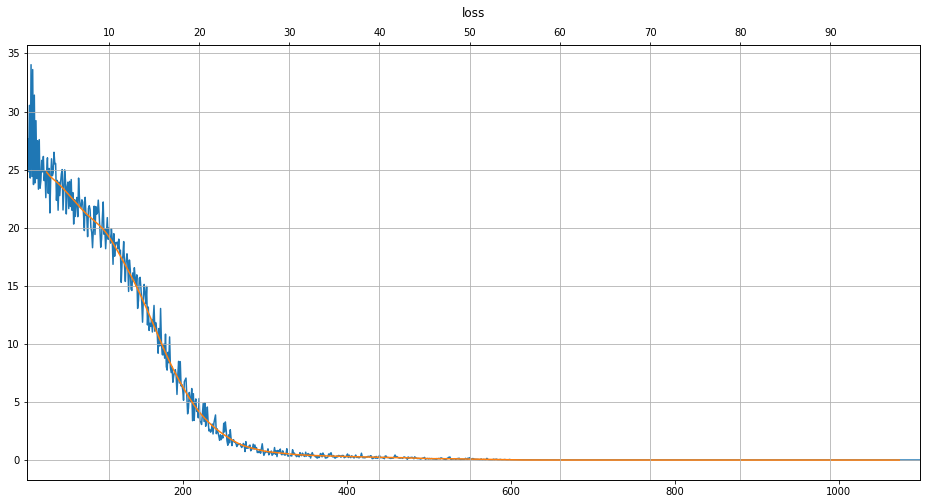

In [10]:
checkdir = './checkpoints/0_crnn_icdar1k'
plot_log(checkdir + '/log.json', ['loss'], [10, np.inf], window_length=50)

./checkpoints/0_crnn_icdar1k_synthtext140k//log.json
['loss']


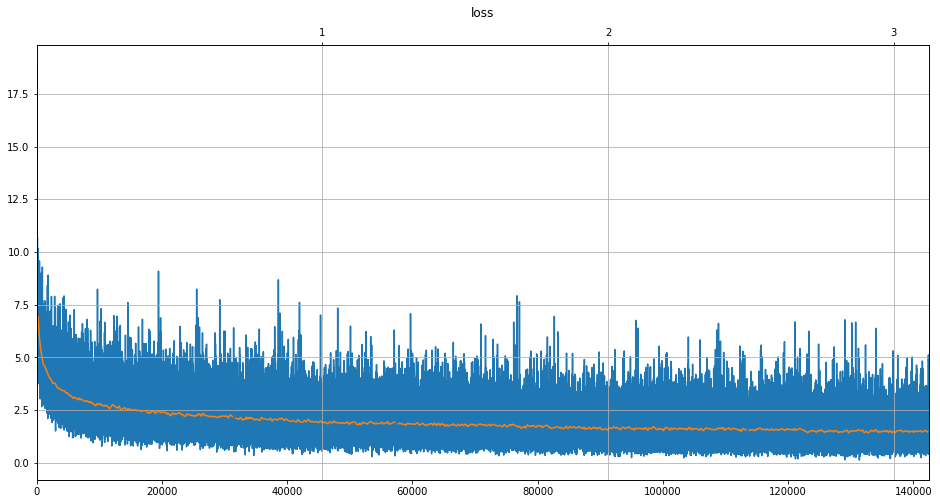

In [11]:
checkdir = './checkpoints/0_crnn_icdar1k_synthtext140k/'
plot_log(checkdir + '/log.json', ['loss'], [10, np.inf], window_length=500)

In [36]:
f = !df -h 
print(f[0], f[3], sep='\n')
f = !nvidia-smi
print('', f[5], f[8], sep='\n')

Filesystem      Size  Used Avail Use% Mounted on
/dev/nvme0n1p2  406G  380G  6,0G  99% /

| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
| 23%   33C    P8    18W / 250W |  10890MiB / 11169MiB |      0%      Default |
